In [1]:
%run data_setup.py

In [2]:
from numpyro.diagnostics import hpdi
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
import scipy.stats as st

# Extremal Treatment Effects
The less uncertainty in a site, the less it gets shrunk towards the global effect. Hence, the more heterogeneity shown in that site.

Question: **Which region pairs illustrate the most heterogeneity?**

How to answer: Look at HPDI of most extreme treatment effects for a small batch of sites e.g. 5 most extreme pairs on either side of the main effect. Do side-by-side for the original data and the bootstrapped data.

## Gravity

In [3]:
with open('../results/hg_fully_partial_results.pkl', 'rb') as f:
    hg_fully_partial_results = pickle.load(f)

In [4]:
β_1_varying = np.concatenate([hg_fully_partial_results['posteriors_model'][x]['β_1'] for x in range(len(hg_fully_partial_results['posteriors_model']))]).reshape(-1,2550)
β_1_common = np.concatenate([hg_fully_partial_results['posteriors_model'][x]['μ_β_1'] for x in range(len(hg_fully_partial_results['posteriors_model']))])

β_1_varying = {df.State_pair.unique()[i] : β_1_varying[:,i] for i in range(len(df.State_pair.unique())) }

effect_sort = sorted(β_1_varying.items(), key=lambda x : hpdi(x[1], 0.95).mean() )

small_3 = effect_sort[:3]
large_3 = effect_sort[-3:]

np.concatenate([[small_3[x][0] for x in range(3)], [large_3[x][0] for x in range(3)]])

array(['Indiana - Maine', 'West Virginia - Iowa',
       'West Virginia - Oregon', 'Alaska - Missouri',
       'California - Wisconsin', 'New York - Virginia'], dtype='<U22')

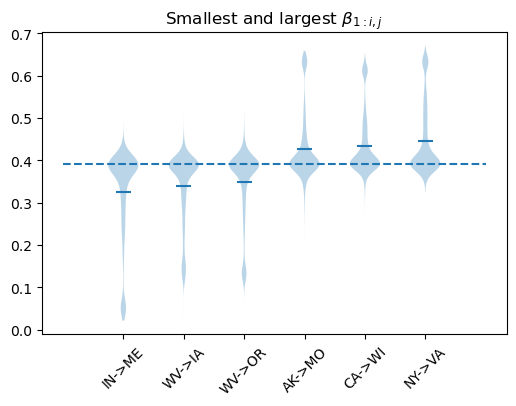

In [5]:
plt.figure(dpi=100)
plt.violinplot(np.concatenate([[small_3[x][1] for x in range(3)], [large_3[x][1] for x in range(3)]]).T, showmeans=True, showextrema=False)
plt.hlines(β_1_common.mean(axis=0), xmin=0, xmax=7, linestyles='dashed')
plt.xticks(np.arange(1,7), ['IN->ME', 'WV->IA', 'WV->OR', 'AK->MO', 'CA->WI', 'NY->VA'], rotation=45)
plt.title('Smallest and largest $\\beta_{1:i,j}$')
plt.show()

In [41]:
param_varying = np.concatenate([hg_fully_partial_results['posteriors_model'][x][['α','β_1','β_2']] for x in range(len(hg_fully_partial_results['posteriors_model']))]).reshape(-1,2550)
β_1_common = np.concatenate([hg_fully_partial_results['posteriors_model'][x][['μ_α','μ_β_1','μ_β_2']] for x in range(len(hg_fully_partial_results['posteriors_model']))])

tmp = df.State_pair.unique()
β_1_varying_posterior = {tmp[i] : β_1_varying[:,i] for i in range(len(tmp))}

In [91]:
param_varying = np.concatenate([hg_fully_partial_results['posteriors_model'][x][['α','β_1','β_2']] for x in range(len(hg_fully_partial_results['posteriors_model']))]).reshape(-1,2550)
# β_1_common = np.concatenate([hg_fully_partial_results['posteriors_model'][x]['μ_β_1'] for x in range(len(hg_fully_partial_results['posteriors_model']))])

vals_to_cluster = ( β_1_varying.mean(axis=0) -  β_1_common.mean() ) / np.sqrt( ( β_1_varying.std(axis=0, ddof=1)**2 + β_1_common.std(ddof=1)**2 ) / 5000 ).reshape(-1,1)

In [12]:
β_1_varying = np.concatenate([hg_fully_partial_results['posteriors_model'][x]['β_1'] for x in range(len(hg_fully_partial_results['posteriors_model']))]).reshape(-1,2550)
# tmp = df.State_pair.unique()
# β_1_varying_posterior_mean = {tmp[i] : β_1_varying[:,i].mean() for i in range(len(tmp))}

vals_to_cluster = β_1_varying.mean(axis=0).reshape(-1,1)
vals_to_cluster = (vals_to_cluster - vals_to_cluster.mean()) / vals_to_cluster.std(ddof=1)

In [8]:
param_varying = np.array([hg_fully_partial_results['posteriors_model'][0][param] for param in ['β_1','β_2']]).mean(axis=1).T
param_common = np.array([hg_fully_partial_results['posteriors_model'][0][param] for param in ['μ_β_1','μ_β_2']]).mean(axis=1).T

param_varying = (param_varying - param_varying.mean(axis=0)) / param_varying.std(axis=0)

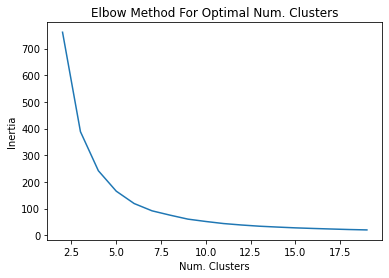

In [8]:
ssd = []
k_rng = range(2,20)
for k in k_rng:
    kmeans = KMeans(n_clusters=k).fit(param_varying)
    ssd += [kmeans.inertia_]
plt.plot(k_rng,ssd)
plt.xlabel('Num. Clusters') 
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Num. Clusters')
plt.show()

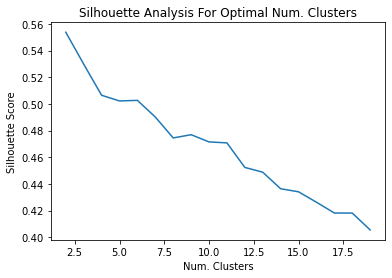

In [9]:
silhouette_avg = []
for k in k_rng:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=k).fit(param_varying)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg += [silhouette_score(param_varying, cluster_labels)]

plt.plot(k_rng,silhouette_avg)
plt.xlabel('Num. Clusters')
plt.ylabel('Silhouette Score') 
plt.title('Silhouette Analysis For Optimal Num. Clusters')
plt.show()

In [9]:
# thanks to rogerallen/us_state_abbrev.py on GitHub
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

state_pair = df.State_pair.unique()
for k in range(len(state_pair)):
    tmp = state_pair[k].split(' - ')
    tmp[0] = us_state_to_abbrev[tmp[0]]
    tmp[1] = us_state_to_abbrev[tmp[1]]
    state_pair[k] = tmp[0] + ' -> ' + tmp[1]

In [14]:
# Calculate the linkage: mergings
mergings = linkage(param_varying, "average", metric="cosine")

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(15, 5), dpi=1000)
dendrogram(mergings, truncate_mode='level', p=5,
           labels=state_pair,
           leaf_rotation=90,
           leaf_font_size=10,
          )
# plt.yticks(ticks=[0.0,0.2,0.4,0.6,0.8], labels=[1.0,0.8,0.6,0.4,0.2])
plt.ylabel("Cosine Similarity", size="x-large")
plt.title("Clustering of posterior means for $(\\alpha_{i,j},\\beta_{1:i,j},\\beta_{2:i,j})$ from HG$_2$", size="x-large");

In [15]:
t = 2
state_pair_clustering = pd.Series(fcluster(mergings, t=t, criterion='maxclust'), index=df.State_pair.unique())

fig, ax = plt.subplots(figsize=(15,6), ncols=2, dpi=1000)
for k in range(t):
    ax[0].hist(param_varying[state_pair_clustering == k+1][:,0], bins=100, alpha=0.7)
    ax[1].hist(param_varying[state_pair_clustering == k+1][:,1], bins=100, alpha=0.7)
    # ax[2].hist(param_varying[state_pair_clustering == k+1][:,2], bins=100, alpha=0.7)


ax[0].set_ylabel("Frequency", size="x-large")
# ax[0].set_xlabel("$\\alpha_{i,j}$", size="x-large")
ax[0].set_xlabel("$\\beta_{1:i,j}$", size="x-large")
ax[1].set_xlabel("$\\beta_{2:i,j}$", size="x-large");

In [16]:
def run_chisq_test(tmp1, tmp2, n_buckets, print_res=True):
    edges = np.linspace(min(tmp1.min(), tmp2.min()),
                max(tmp1.max(), tmp2.max()),
                n_buckets)
    hist1 = [ np.sum((tmp1 > edges[i]) & (tmp1 <= edges[i+1])) for i in range(n_buckets-1) ]
    hist2 = [ np.sum((tmp2 > edges[i]) & (tmp2 <= edges[i+1])) for i in range(n_buckets-1) ]
    observed = np.array([hist1, hist2])

    # Calculate totals
    row_totals = np.array([np.sum(observed, axis=1)])
    col_totals = np.array([np.sum(observed, axis=0)])
    n = np.sum(observed)
    # Calculate the expected observations
    expected = np.dot(row_totals.T, col_totals) / n

    # Calculate the chi-square test statistic
    chisq, p_value = st.chisquare(observed, expected)
    # Sum the answers
    chisq = np.sum(chisq)
    # Degrees of freedom
    rows = observed.shape[0]
    cols = observed.shape[1]
    dof = (rows - 1) * (cols - 1)
    # Convert chi-square test statistic to p-value
    p_value = 1 - st.chi2.cdf(chisq, dof)

    if print_res:
        print(f'χ² = {chisq:.3f}, p = {p_value:.3f}')
    return p_value

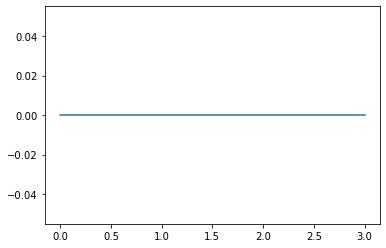

In [20]:
pvals = []
tmp1 = param_varying[state_pair_clustering == 1][:,0]
tmp2 = param_varying[state_pair_clustering == 2][:,0]
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        continue
    else:
        pvals += [p]

plt.plot(pvals);

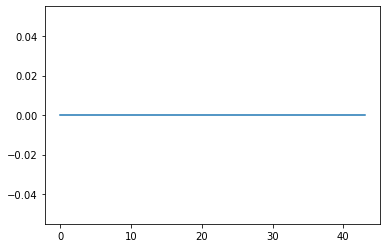

In [19]:
pvals = []
tmp1 = param_varying[state_pair_clustering == 1][:,1]
tmp2 = param_varying[state_pair_clustering == 2][:,1]
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Distance distribution for each cluster

In [21]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
distances_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    distances_cluster_1[i] = distance.loc[tmp1[0],tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 2].index
distances_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    distances_cluster_2[i] = distance.loc[tmp1[0],tmp1[1]]

Text(0.5, 1.0, 'Distribution of $D_{i,j}$ for each cluster')

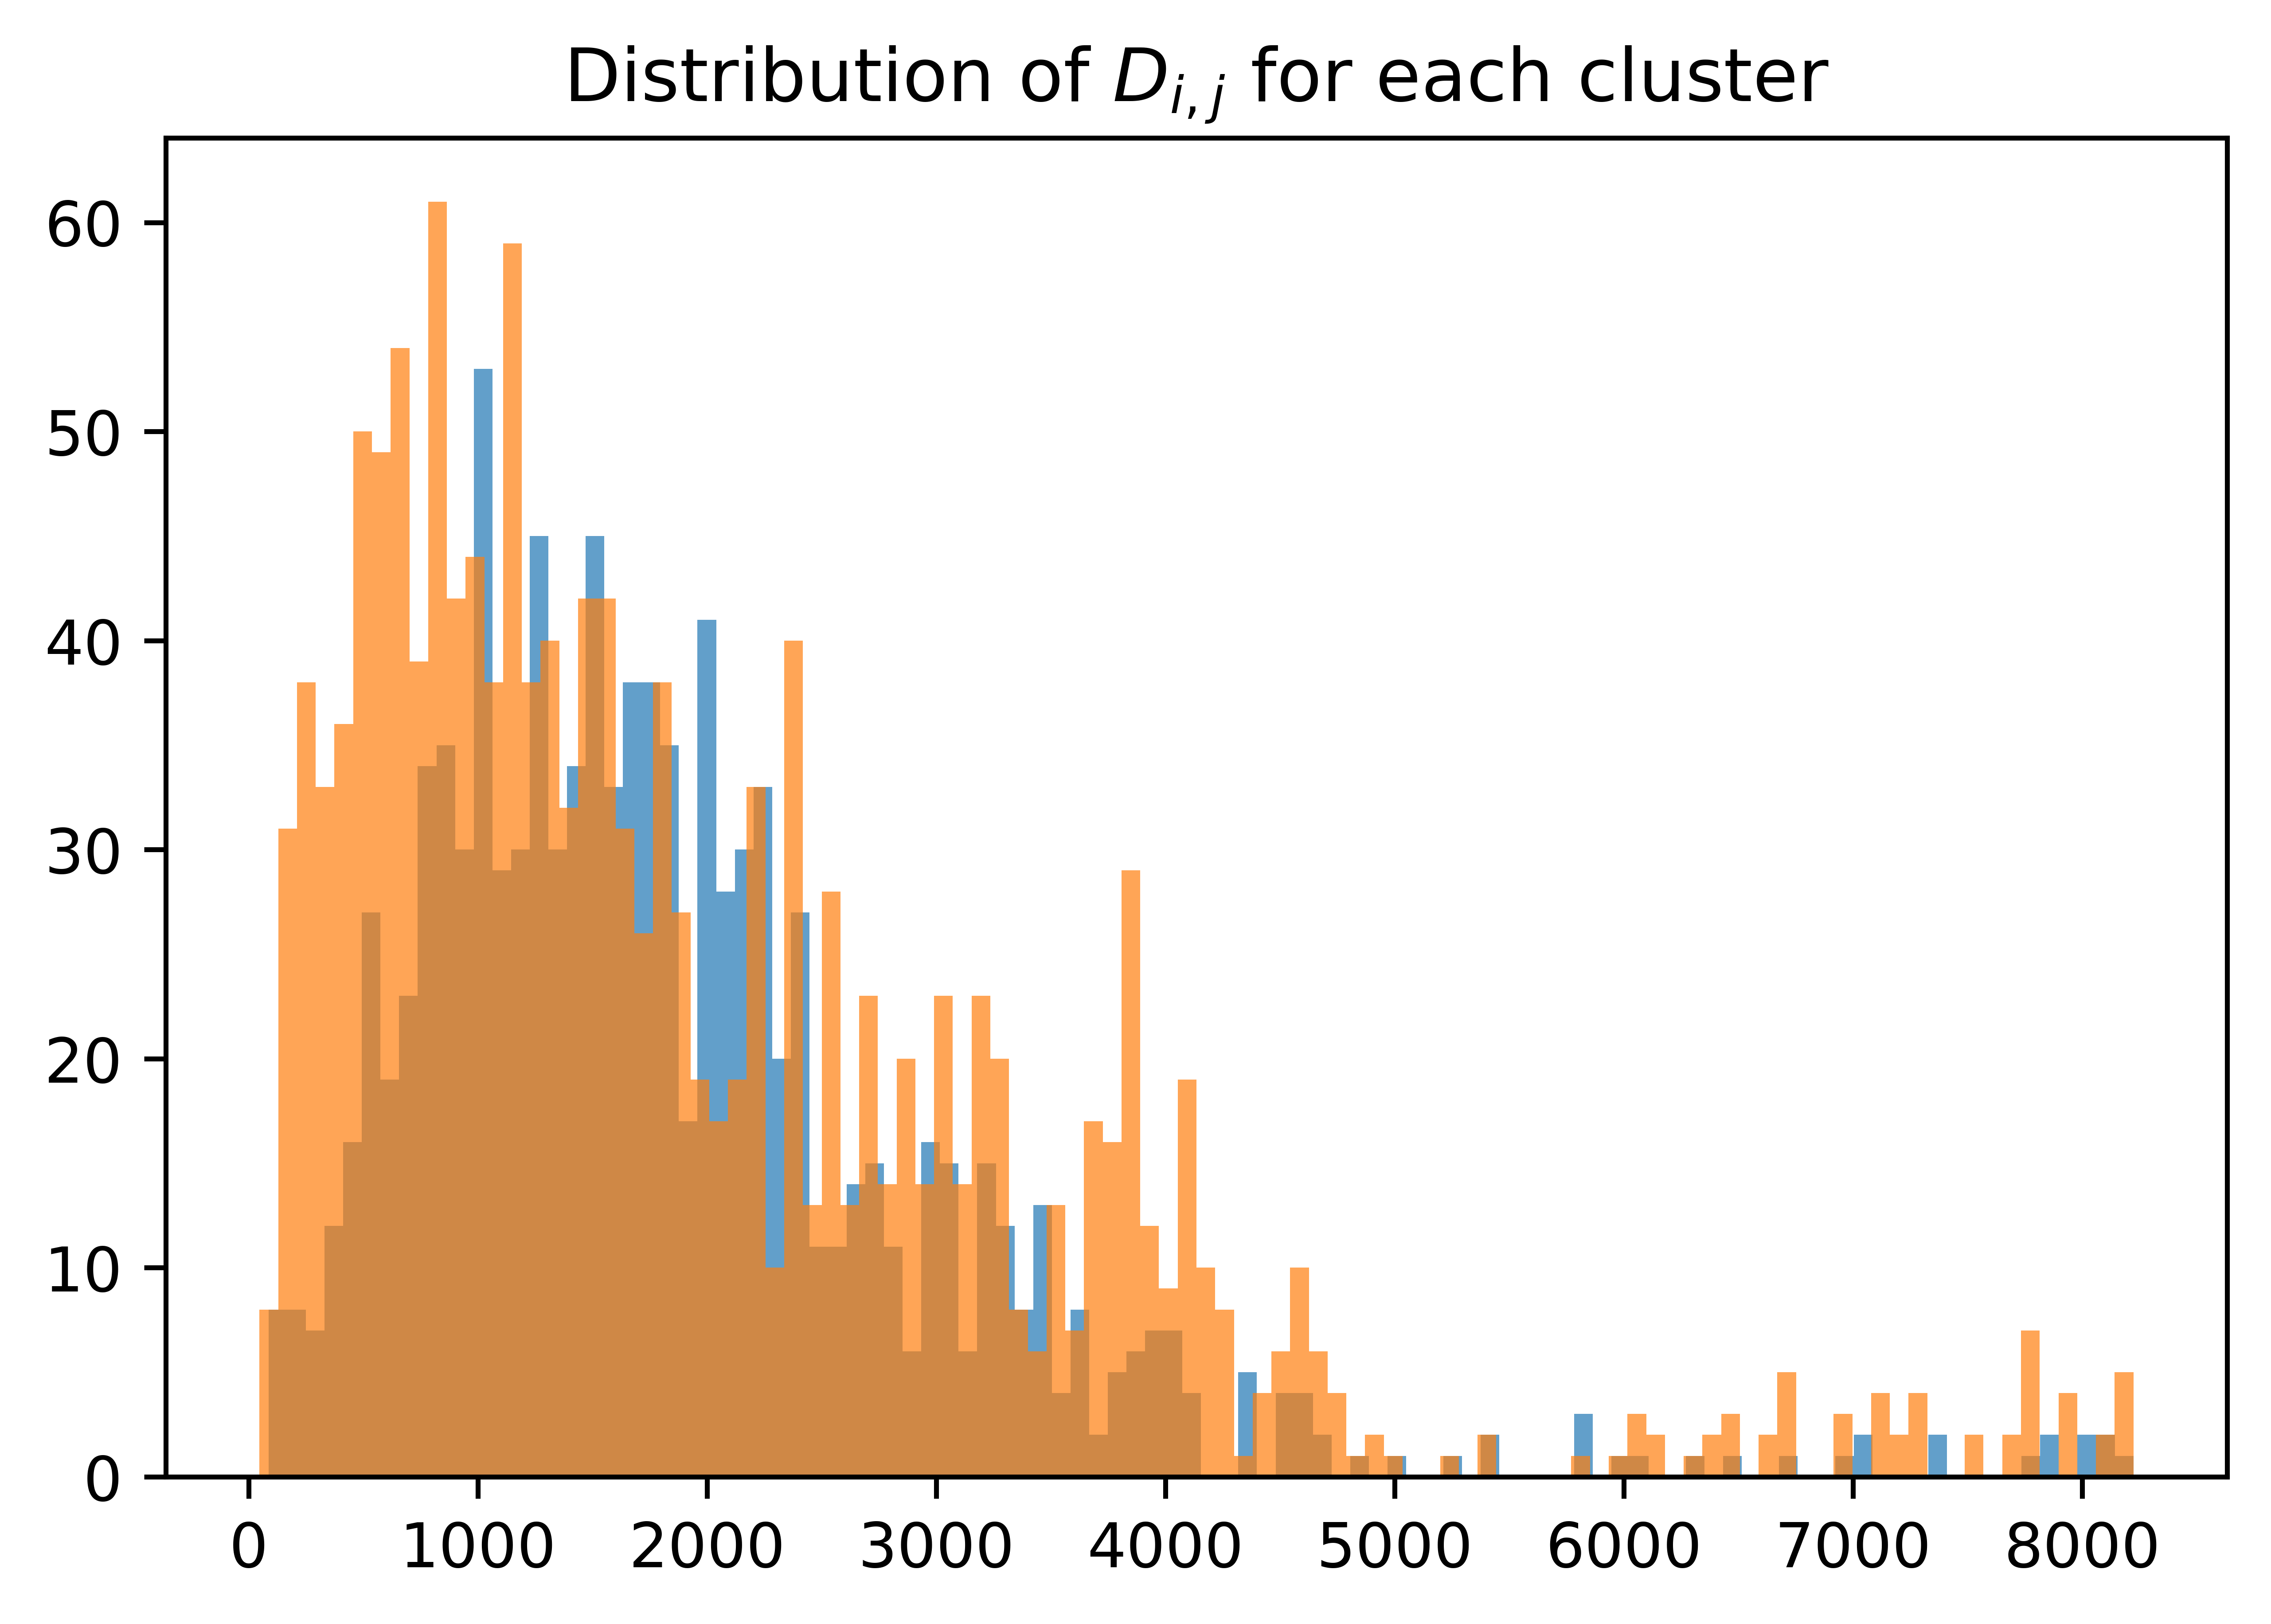

In [22]:
plt.figure(dpi=1000)
plt.hist(distances_cluster_1, bins=100, alpha=0.7)
plt.hist(distances_cluster_2, bins=100, alpha=0.7)
plt.title("Distribution of $D_{i,j}$ for each cluster")

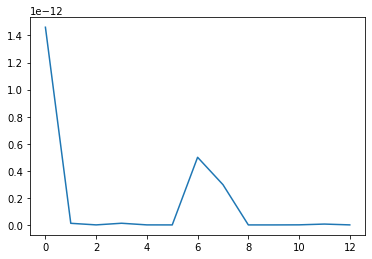

In [23]:
pvals = []
tmp1 = np.array(np.log(distances_cluster_1))
tmp2 = np.array(np.log(distances_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals)

### Population ratio distribution for each cluster

In [24]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
popmean_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    popmean_cluster_1[i] = np.mean([population.mean(axis=0)[tmp1[0]] , population.mean(axis=0)[tmp1[1]]])

tmp = state_pair_clustering[state_pair_clustering == 2].index
popmean_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    popmean_cluster_2[i] = np.mean([population.mean(axis=0)[tmp1[0]] , population.mean(axis=0)[tmp1[1]]])

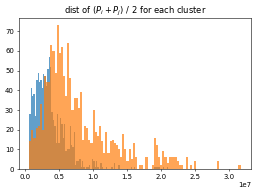

In [25]:
plt.figure(dpi=50)
plt.hist(popmean_cluster_1, bins=100, alpha=0.7)
plt.hist(popmean_cluster_2, bins=100, alpha=0.7)
plt.title("dist of $({P_i} + {P_j}) ~/~ 2$ for each cluster");

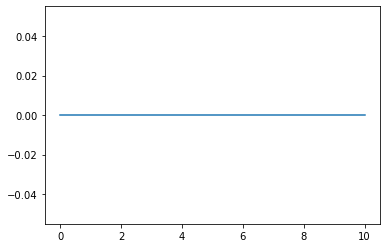

In [26]:
pvals = []
tmp1 = np.array(popmean_cluster_1)
tmp2 = np.array(popmean_cluster_2)
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals)

### Income ratio distribution for each cluster

In [27]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
incomeratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    incomeratio_cluster_1[i] = income.mean(axis=0)[tmp1[0]] / income.mean(axis=0)[tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 2].index
incomeratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    incomeratio_cluster_2[i] = income.mean(axis=0)[tmp1[0]] / income.mean(axis=0)[tmp1[1]]

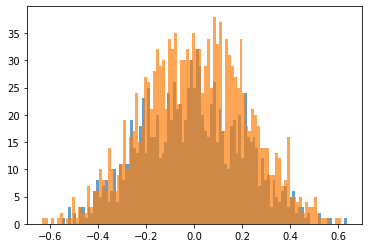

In [28]:
plt.hist(np.log(incomeratio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(incomeratio_cluster_2), bins=100, alpha=0.7);

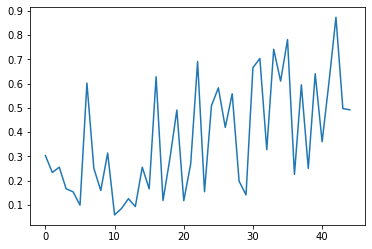

In [29]:
pvals = []
tmp1 = np.array(np.log(incomeratio_cluster_1))
tmp2 = np.array(np.log(incomeratio_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Affordability ratio distribution for each cluster

In [30]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
affordabilityratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    affordabilityratio_cluster_1[i] = affordability.mean(axis=0)[tmp1[0]] / affordability.mean(axis=0)[tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 2].index
affordabilityratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    affordabilityratio_cluster_2[i] = affordability.mean(axis=0)[tmp1[0]] / affordability.mean(axis=0)[tmp1[1]]

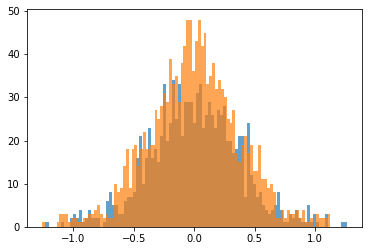

In [31]:
plt.hist(np.log(affordabilityratio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(affordabilityratio_cluster_2), bins=100, alpha=0.7);

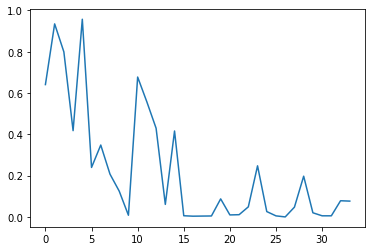

In [32]:
pvals = []
tmp1 = np.array(np.log(affordabilityratio_cluster_1))
tmp2 = np.array(np.log(affordabilityratio_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Area ratio distribution for each cluster

In [33]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
arearatio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    arearatio_cluster_1[i] = area.loc[tmp1[0]][0] / area.loc[tmp1[1]][0]

tmp = state_pair_clustering[state_pair_clustering == 2].index
arearatio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    arearatio_cluster_2[i] = area.loc[tmp1[0]][0] / area.loc[tmp1[1]][0]

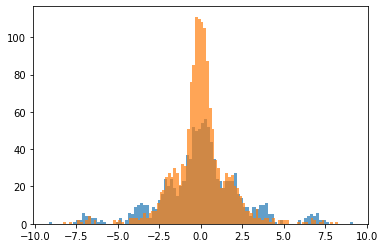

In [34]:
plt.hist(np.log(arearatio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(arearatio_cluster_2), bins=100, alpha=0.7);

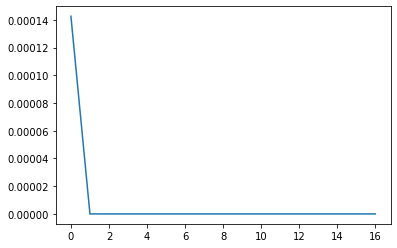

In [35]:
pvals = []
tmp1 = np.array(np.log(arearatio_cluster_1))
tmp2 = np.array(np.log(arearatio_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Housing ratio distribution for each cluster

In [36]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
housingratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    housingratio_cluster_1[i] = housing.mean(axis=0)[tmp1[0]] / housing.mean(axis=0)[tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 2].index
housingratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    housingratio_cluster_2[i] = housing.mean(axis=0)[tmp1[0]] / housing.mean(axis=0)[tmp1[1]]

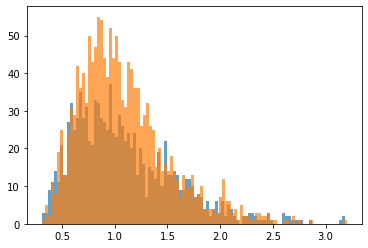

In [37]:
plt.hist(housingratio_cluster_1, bins=100, alpha=0.7)
plt.hist(housingratio_cluster_2, bins=100, alpha=0.7);

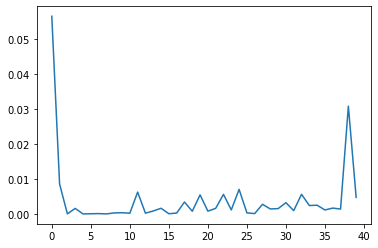

In [38]:
pvals = []
tmp1 = np.array(np.log(housingratio_cluster_1))
tmp2 = np.array(np.log(housingratio_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Climate cost ratio distribution for each cluster

In [39]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
climateratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    climateratio_cluster_1[i] = np.log(1+df.query("State_i == '{}'".format(tmp1[0])).ADC_i.mean()) - np.log(1+df.query("State_i == '{}'".format(tmp1[1])).ADC_i.mean())

tmp = state_pair_clustering[state_pair_clustering == 2].index
climateratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    climateratio_cluster_2[i] = np.log(1+df.query("State_i == '{}'".format(tmp1[0])).ADC_i.mean()) - np.log(1+df.query("State_i == '{}'".format(tmp1[1])).ADC_i.mean())

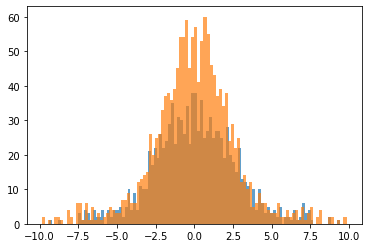

In [40]:
plt.hist(climateratio_cluster_1, bins=100, alpha=0.7)
plt.hist(climateratio_cluster_2, bins=100, alpha=0.7);

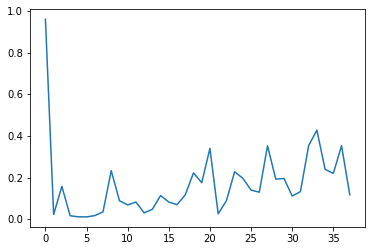

In [41]:
pvals = []
tmp1 = np.array(climateratio_cluster_1)
tmp2 = np.array(climateratio_cluster_2)
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Population density distribution for each cluster

In [42]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
densityratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    densityratio_cluster_1[i] = df.query("State_i == '{}'".format(tmp1[0])).rho_i.mean() / df.query("State_i == '{}'".format(tmp1[1])).rho_i.mean()

tmp = state_pair_clustering[state_pair_clustering == 2].index
densityratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    densityratio_cluster_2[i] =  df.query("State_i == '{}'".format(tmp1[0])).rho_i.mean() / df.query("State_i == '{}'".format(tmp1[1])).rho_i.mean()

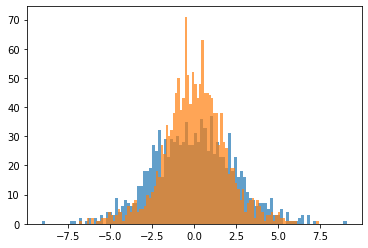

In [43]:
plt.hist(np.log(densityratio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(densityratio_cluster_2), bins=100, alpha=0.7);

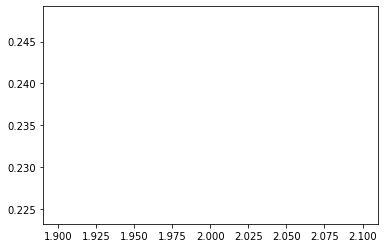

In [44]:
pvals = []
tmp1 = np.array(densityratio_cluster_1)
tmp2 = np.array(densityratio_cluster_2)
for n_buckets in range(1,100):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Difference in flow

In [45]:
tmp = state_pair_clustering[state_pair_clustering == 1].index
flow_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    flow_cluster_1[i] = df.query("State_pair == '{}'".format(tmp[i])).M_ij_mean.mean()

tmp = state_pair_clustering[state_pair_clustering == 2].index
flow_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    flow_cluster_2[i] = df.query("State_pair == '{}'".format(tmp[i])).M_ij_mean.mean()

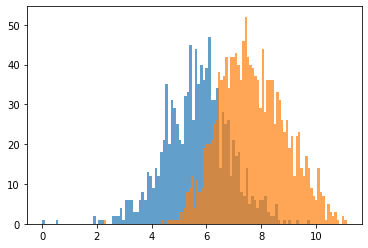

In [46]:
plt.hist(np.log(1 + np.array(flow_cluster_1)), bins=100, alpha=0.7)
plt.hist(np.log(1 + np.array(flow_cluster_2)), bins=100, alpha=0.7);

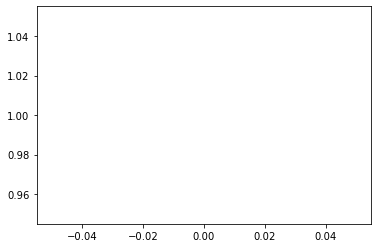

In [47]:
pvals = []
tmp1 = np.log(1 + np.array(flow_cluster_2))
tmp2 = np.log(1 + np.array(flow_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.nan:
        break
    else:
        pvals += [p]

plt.plot(pvals)

### Subplots for significantly different conditional distributions

In [50]:
import matplotlib.transforms as mtransforms

fig, axs = plt.subplot_mosaic([['hier_cluster','hier_cluster','hier_cluster'],
                               ['β_1', 'β_1', 'β_2'],
                               ['Flow', 'Population', 'Distance'],
                               ['Housing','Area','Climate']],
                              layout='constrained',
                              dpi=1000,
                              figsize=(12,12))

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    if label == 'hier_cluster':
        dendrogram(mergings, truncate_mode='level', p=5,
                labels=state_pair,
                leaf_rotation=90,
                leaf_font_size=5,
                ax=ax
                )
        ax.set_yticks(ticks=[0.0,0.2,0.4,0.6,0.8], labels=[1.0,0.8,0.6,0.4,0.2])
        ax.set_ylabel("Cosine Similarity")
        ax.set_xlabel("State pair (i -> j)")
        ax.set_title("Clustering of posterior means for $(\\beta_{1:i,j},\\beta_{2:i,j})$ from HG$_2$")
    # elif label == 'α':
    #     ax.hist(param_varying[state_pair_clustering == 1][:,0], bins=100, alpha=0.7)
    #     ax.hist(param_varying[state_pair_clustering == 2][:,0], bins=100, alpha=0.7)
    #     ax.axvline(param_common[0], label="$\\mu_\\alpha$", linestyle="--")
    #     ax.text(0.0, 1.0, 'p-value = 0.000', transform=ax.transAxes + trans,
    #         fontsize='medium', verticalalignment='top', fontfamily='serif',
    #         bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    #     ax.set_ylabel("Frequency")
    #     ax.set_xlabel("$\\alpha_{i,j}$")
    #     ax.legend()
    elif label == 'β_1':
        ax.hist(param_varying[state_pair_clustering == 1][:,0], bins=100, alpha=0.7)
        ax.hist(param_varying[state_pair_clustering == 2][:,0], bins=100, alpha=0.7)
        # ax.axvline(param_common[0], label="$\\mu_{\\beta_1}$", linestyle="--")
        ax.text(0.0, 1.0, 'p-value = 0.000', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
        ax.set_xlabel("$\\beta_{1:i,j}$")
        ax.legend()
    elif label == 'β_2':
        ax.hist(param_varying[state_pair_clustering == 1][:,1], bins=100, alpha=0.7)
        ax.hist(param_varying[state_pair_clustering == 2][:,1], bins=100, alpha=0.7)
        # ax.axvline(param_common[1], label="$\\mu_{\\beta_2}$", linestyle="--")
        ax.text(0.0, 1.0, 'p-value = 0.000', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
        ax.set_xlabel("$\\beta_{2:i,j}$")
        ax.legend()
    elif label == 'Flow':
        ax.hist(np.log(1 + np.array(flow_cluster_1)), bins=100, alpha=0.7)
        ax.hist(np.log(1 + np.array(flow_cluster_2)), bins=100, alpha=0.7)
        ax.set_ylabel("Frequency")
        ax.set_xlabel("$\\log M_{i,j}$")
        ax.text(0.0, 1.0, 'p-value = 0.000', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    elif label == 'Population':
        ax.hist(popmean_cluster_1, bins=100, alpha=0.7)
        ax.hist(popmean_cluster_2, bins=100, alpha=0.7)
        ax.set_xlabel("$(P_i + P_j)~/~2$")
        ax.text(0.0, 1.0, 'p-value = 0.000', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    elif label == 'Distance':
        ax.hist(distances_cluster_1, bins=100, alpha=0.7)
        ax.hist(distances_cluster_2, bins=100, alpha=0.7)
        ax.set_xlabel("$D_{i,j}$")
        ax.text(0.0, 1.0, 'p-value = 0.012', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    elif label == 'Housing':
        ax.hist(np.log(housingratio_cluster_1), bins=100, alpha=0.7)
        ax.hist(np.log(housingratio_cluster_2), bins=100, alpha=0.7)
        ax.set_xlabel("$\\log(H_i~/~H_j)$")
        ax.text(0.0, 1.0, 'p-value = 0.037', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
        ax.set_ylabel("Frequency")
    elif label == 'Area':
        ax.hist(np.log(arearatio_cluster_1), bins=100, alpha=0.7)
        ax.hist(np.log(arearatio_cluster_2), bins=100, alpha=0.7)
        ax.set_xlabel("$\\log(A_i~/~A_j)$")
        ax.text(0.0, 1.0, 'p-value = 0.023', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
    else:
        ax.hist(climateratio_cluster_1, bins=100, alpha=0.7)
        ax.hist(climateratio_cluster_2, bins=100, alpha=0.7)
        ax.set_xlabel("$\\log(C_i~/~C_j)$")
        ax.text(0.0, 1.0, 'p-value = 0.027', transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


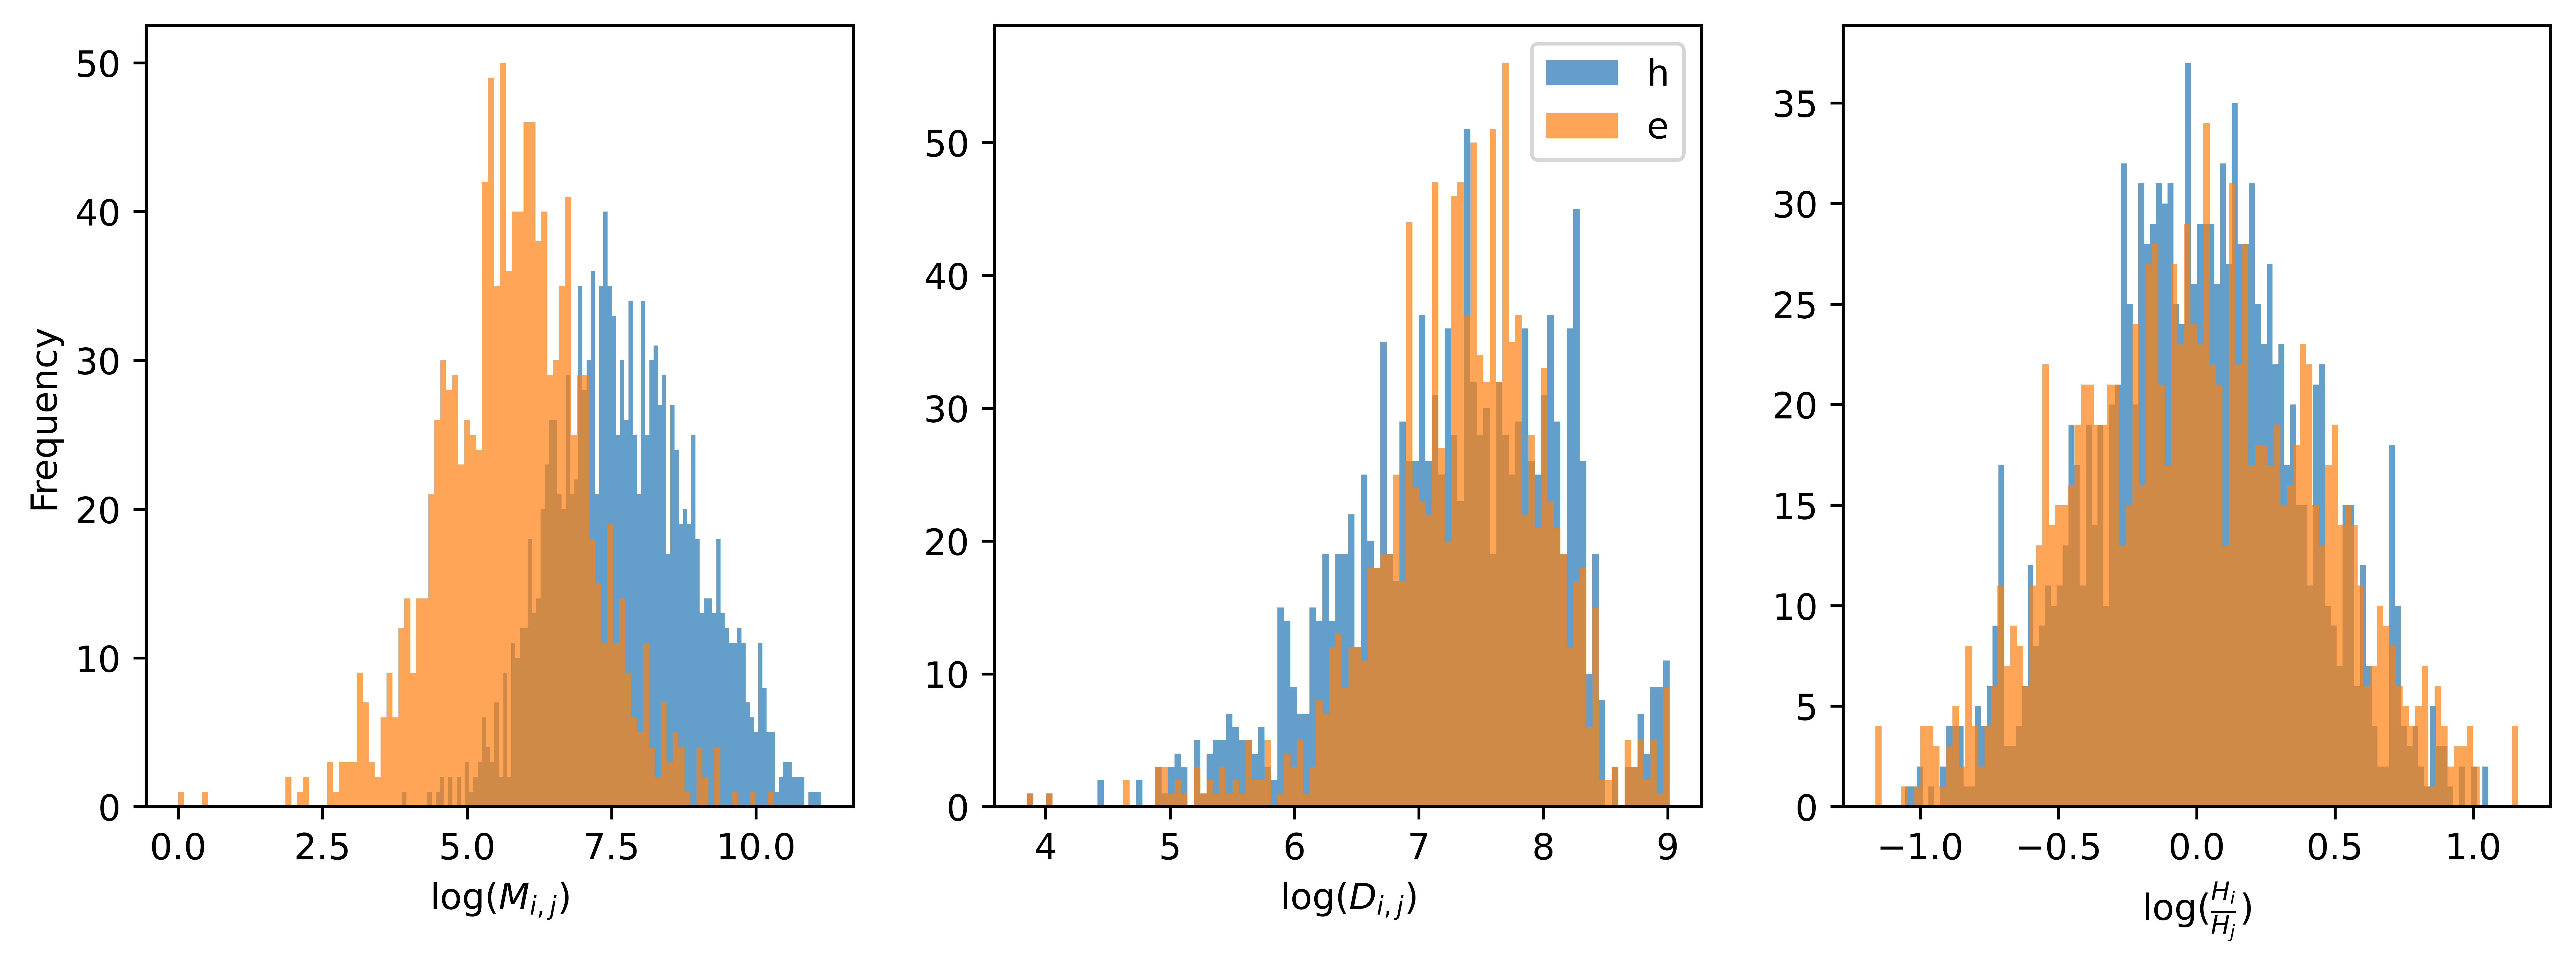

In [273]:
fig, ax = plt.subplots(ncols=3, nrows=1, dpi=1000, figsize=(12,4))

## flow

ax[0].hist(np.log(1 + np.array(flow_cluster_1)), bins=100, alpha=0.7)
ax[0].hist(np.log(1 + np.array(flow_cluster_2)), bins=100, alpha=0.7)
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("$\\log(M_{i,j})$")

## distance

ax[1].hist(np.log(distances_cluster_1), bins=100, alpha=0.7)
ax[1].hist(np.log(distances_cluster_2), bins=100, alpha=0.7)
ax[1].set_xlabel("$\\log(D_{i,j})$")
ax[1].legend("hello")

## housing index ratio

ax[2].hist(np.log(housingratio_cluster_1), bins=100, alpha=0.7)
ax[2].hist(np.log(housingratio_cluster_2), bins=100, alpha=0.7)
ax[2].set_xlabel("$\\log(\\frac{H_i}{H_j})$");

# ## land area ratio

# ax[0].hist(np.log(arearatio_cluster_1), bins=100, alpha=0.7)
# ax[0].hist(np.log(arearatio_cluster_2), bins=100, alpha=0.7);

# ## climate cost difference

# ax[1].hist(climateratio_cluster_1, bins=100, alpha=0.7)
# ax[1].hist(climateratio_cluster_2, bins=100, alpha=0.7);


## Radiation

In [202]:
with open('../results/hr_fully_partial_results.pkl', 'rb') as f:
    hr_fully_partial_results = pickle.load(f)

In [203]:
param_varying = np.array([hr_fully_partial_results['posteriors_model'][0][param] for param in ['α','β_1','β_2','β_3','β_4']]).mean(axis=1).T

param_varying

array([[ 1.2235067 ,  0.6107998 ,  0.5403624 , -1.0571359 ,  0.4696548 ],
       [ 1.157256  ,  0.61219925,  0.5394506 , -1.074258  ,  0.4629411 ],
       [ 0.8331597 ,  0.6056803 ,  0.53763086, -1.1408967 ,  0.44446042],
       ...,
       [ 1.1762986 ,  0.61178076,  0.5404954 , -1.0650798 ,  0.46746552],
       [ 0.48458558,  0.5980833 ,  0.5346447 , -1.2318252 ,  0.42897066],
       [ 0.9721635 ,  0.6090275 ,  0.538697  , -1.1115696 ,  0.45171183]],
      dtype=float32)

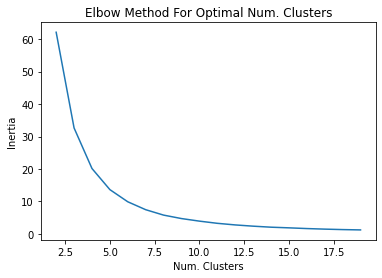

In [204]:
ssd = []
k_rng = range(2,20)
for k in k_rng:
    kmeans = KMeans(n_clusters=k).fit(param_varying)
    ssd += [kmeans.inertia_]
plt.plot(k_rng,ssd)
plt.xlabel('Num. Clusters') 
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Num. Clusters')
plt.show()

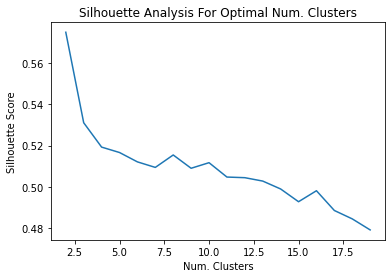

In [205]:
silhouette_avg = []
for k in k_rng:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=k).fit(param_varying)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg += [silhouette_score(param_varying, cluster_labels)]

plt.plot(k_rng,silhouette_avg)
plt.xlabel('Num. Clusters')
plt.ylabel('Silhouette Score') 
plt.title('Silhouette Analysis For Optimal Num. Clusters')
plt.show()

In [206]:
# thanks to rogerallen/us_state_abbrev.py on GitHub
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

state_pair = df.State_pair.unique()
for k in range(len(state_pair)):
    tmp = state_pair[k].split(' - ')
    tmp[0] = us_state_to_abbrev[tmp[0]]
    tmp[1] = us_state_to_abbrev[tmp[1]]
    state_pair[k] = tmp[0] + ' -> ' + tmp[1]

In [209]:
# Calculate the linkage: mergings
mergings = linkage(param_varying, "average", metric="cosine")

# Plot the dendrogram, using varieties as labels
plt.figure(figsize=(15, 5), dpi=1000)
dendrogram(mergings, truncate_mode='level', p=5,
           labels=state_pair,
           leaf_rotation=90,
           leaf_font_size=10,
          )
ticks = np.array([0.0,0.02,0.04,0.06,0.08,0.10,0.12])
plt.yticks(ticks=ticks, labels=1-ticks)
plt.ylabel("Cosine Similarity", size="x-large")
plt.title("Clustering of posterior means for $(\\alpha_{i,j},\\beta_{1:i,j},\\beta_{2:i,j})$ from HG$_2$", size="x-large");

In [214]:
t = 3
state_pair_clustering = pd.Series(fcluster(mergings, t=t, criterion='maxclust'), index=df.State_pair.unique())

fig, ax = plt.subplots(figsize=(15,6), ncols=5, dpi=1000)
for k in range(1,t):
    ax[0].hist(param_varying[state_pair_clustering == k+1][:,0], bins=100, alpha=0.7)
    ax[1].hist(param_varying[state_pair_clustering == k+1][:,1], bins=100, alpha=0.7)
    ax[2].hist(param_varying[state_pair_clustering == k+1][:,2], bins=100, alpha=0.7)
    ax[3].hist(param_varying[state_pair_clustering == k+1][:,3], bins=100, alpha=0.7)
    ax[4].hist(param_varying[state_pair_clustering == k+1][:,4], bins=100, alpha=0.7)

ax[0].set_ylabel("Frequency", size="x-large")
ax[0].set_xlabel("$\\alpha_{i,j}$", size="x-large")
ax[1].set_xlabel("$\\beta_{1:i,j}$", size="x-large")
ax[2].set_xlabel("$\\beta_{2:i,j}$", size="x-large")
ax[3].set_xlabel("$\\beta_{3:i,j}$", size="x-large")
ax[4].set_xlabel("$\\beta_{4:i,j}$", size="x-large");

In [215]:
def run_chisq_test(tmp1, tmp2, n_buckets, print_res=True):
    edges = np.linspace(min(tmp1.min(), tmp2.min()),
                max(tmp1.max(), tmp2.max()),
                n_buckets)
    hist1 = [ np.sum((tmp1 > edges[i]) & (tmp1 <= edges[i+1])) for i in range(n_buckets-1) ]
    hist2 = [ np.sum((tmp2 > edges[i]) & (tmp2 <= edges[i+1])) for i in range(n_buckets-1) ]
    observed = np.array([hist1, hist2])

    # Calculate totals
    row_totals = np.array([np.sum(observed, axis=1)])
    col_totals = np.array([np.sum(observed, axis=0)])
    n = np.sum(observed)
    # Calculate the expected observations
    expected = np.dot(row_totals.T, col_totals) / n

    # Calculate the chi-square test statistic
    chisq, p_value = st.chisquare(observed, expected)
    # Sum the answers
    chisq = np.sum(chisq)
    # Degrees of freedom
    rows = observed.shape[0]
    cols = observed.shape[1]
    dof = (rows - 1) * (cols - 1)
    # Convert chi-square test statistic to p-value
    p_value = 1 - st.chi2.cdf(chisq, dof)

    if print_res:
        print(f'χ² = {chisq:.3f}, p = {p_value:.3f}')
    return p_value

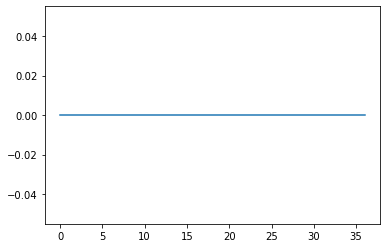

In [216]:
pvals = []
tmp1 = param_varying[state_pair_clustering == 2][:,1]
tmp2 = param_varying[state_pair_clustering == 3][:,1]
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        continue
    else:
        pvals += [p]

plt.plot(pvals);

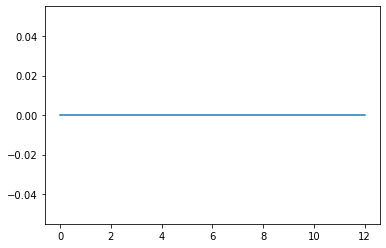

In [217]:
pvals = []
tmp1 = param_varying[state_pair_clustering == 2][:,2]
tmp2 = param_varying[state_pair_clustering == 3][:,2]
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Distance distribution for each cluster

In [218]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
distances_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    distances_cluster_1[i] = distance.loc[tmp1[0],tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 3].index
distances_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    distances_cluster_2[i] = distance.loc[tmp1[0],tmp1[1]]

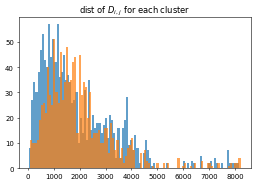

In [219]:
plt.figure(dpi=50)
plt.hist(distances_cluster_1, bins=100, alpha=0.7)
plt.hist(distances_cluster_2, bins=100, alpha=0.7)
plt.title("dist of $D_{i,j}$ for each cluster");

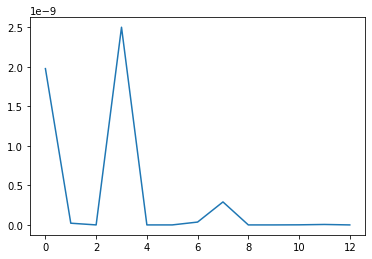

In [220]:
pvals = []
tmp1 = np.array(np.log(distances_cluster_1))
tmp2 = np.array(np.log(distances_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Population ratio distribution for each cluster

In [221]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
popratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    popratio_cluster_1[i] = population.mean(axis=0)[tmp1[0]] / population.mean(axis=0)[tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 3].index
popratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    popratio_cluster_2[i] = population.mean(axis=0)[tmp1[0]] / population.mean(axis=0)[tmp1[1]]

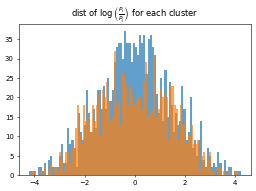

In [222]:
plt.figure(dpi=50)
plt.hist(np.log(popratio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(popratio_cluster_2), bins=100, alpha=0.7)
plt.title("dist of $\\log\\left(\\frac{P_i}{P_j}\\right)$ for each cluster");

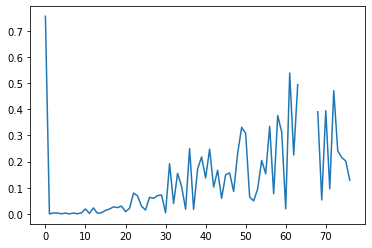

In [224]:
pvals = []
tmp1 = np.array(np.log(popratio_cluster_1))
tmp2 = np.array(np.log(popratio_cluster_2))
for n_buckets in range(5,100):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Income ratio distribution for each cluster

In [225]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
incomeratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    incomeratio_cluster_1[i] = income.mean(axis=0)[tmp1[0]] / income.mean(axis=0)[tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 3].index
incomeratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    incomeratio_cluster_2[i] = income.mean(axis=0)[tmp1[0]] / income.mean(axis=0)[tmp1[1]]

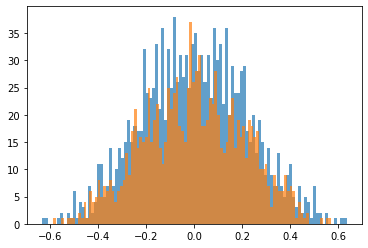

In [226]:
plt.hist(np.log(incomeratio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(incomeratio_cluster_2), bins=100, alpha=0.7);

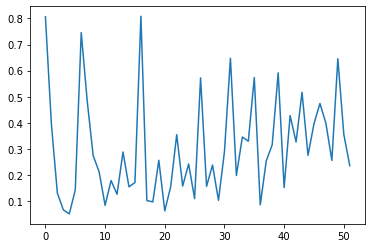

In [229]:
pvals = []
tmp1 = np.array(np.log(incomeratio_cluster_1))
tmp2 = np.array(np.log(incomeratio_cluster_2))
for n_buckets in range(5,100):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Affordability ratio distribution for each cluster

In [230]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
affordabilityratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    affordabilityratio_cluster_1[i] = affordability.mean(axis=0)[tmp1[0]] / affordability.mean(axis=0)[tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 3].index
affordabilityratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    affordabilityratio_cluster_2[i] = affordability.mean(axis=0)[tmp1[0]] / affordability.mean(axis=0)[tmp1[1]]

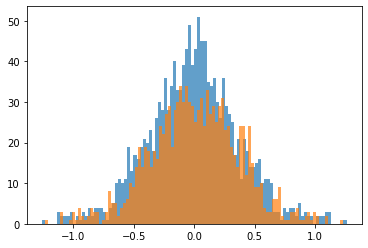

In [231]:
plt.hist(np.log(affordabilityratio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(affordabilityratio_cluster_2), bins=100, alpha=0.7);

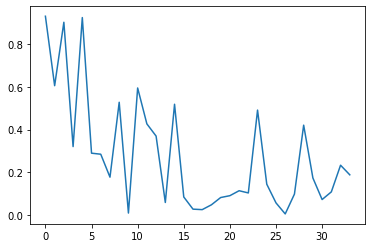

In [232]:
pvals = []
tmp1 = np.array(np.log(affordabilityratio_cluster_1))
tmp2 = np.array(np.log(affordabilityratio_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Area ratio distribution for each cluster

In [233]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
arearatio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    arearatio_cluster_1[i] = area.loc[tmp1[0]][0] / area.loc[tmp1[1]][0]

tmp = state_pair_clustering[state_pair_clustering == 3].index
arearatio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    arearatio_cluster_2[i] = area.loc[tmp1[0]][0] / area.loc[tmp1[1]][0]

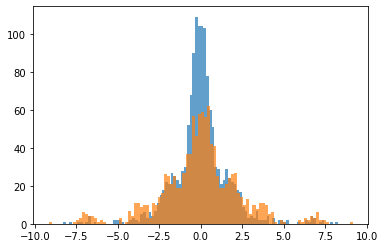

In [234]:
plt.hist(np.log(arearatio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(arearatio_cluster_2), bins=100, alpha=0.7);

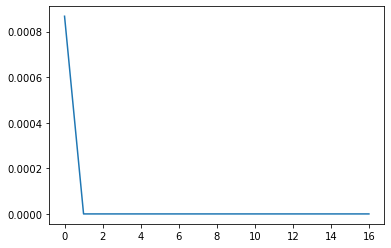

In [235]:
pvals = []
tmp1 = np.array(np.log(arearatio_cluster_1))
tmp2 = np.array(np.log(arearatio_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Housing ratio distribution for each cluster

In [236]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
housingratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    housingratio_cluster_1[i] = housing.mean(axis=0)[tmp1[0]] / housing.mean(axis=0)[tmp1[1]]

tmp = state_pair_clustering[state_pair_clustering == 3].index
housingratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    housingratio_cluster_2[i] = housing.mean(axis=0)[tmp1[0]] / housing.mean(axis=0)[tmp1[1]]

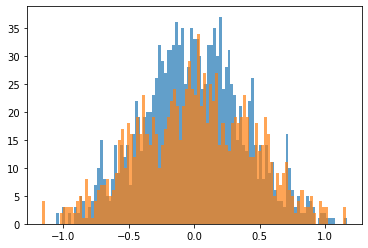

In [237]:
plt.hist(np.log(housingratio_cluster_1), bins=100, alpha=0.7)
plt.hist(np.log(housingratio_cluster_2), bins=100, alpha=0.7);

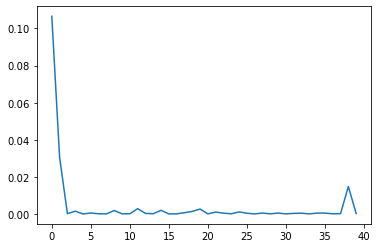

In [238]:
pvals = []
tmp1 = np.array(np.log(housingratio_cluster_1))
tmp2 = np.array(np.log(housingratio_cluster_2))
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Climate cost ratio distribution for each cluster

In [239]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
climateratio_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    climateratio_cluster_1[i] = df.query("State_i == '{}'".format(tmp1[0])).ADC_i.mean() - df.query("State_i == '{}'".format(tmp1[1])).ADC_i.mean()

tmp = state_pair_clustering[state_pair_clustering == 3].index
climateratio_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    tmp1 = tmp[i].split(' - ')
    climateratio_cluster_2[i] = df.query("State_i == '{}'".format(tmp1[0])).ADC_i.mean() - df.query("State_i == '{}'".format(tmp1[1])).ADC_i.mean()

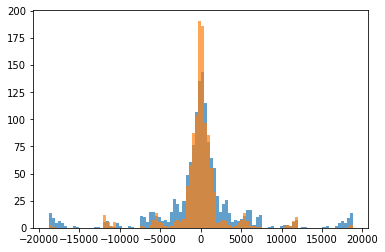

In [240]:
plt.hist(climateratio_cluster_1, bins=100, alpha=0.7)
plt.hist(climateratio_cluster_2, bins=100, alpha=0.7);

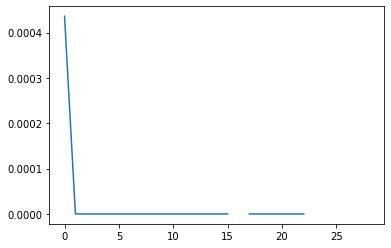

In [241]:
pvals = []
tmp1 = np.array(climateratio_cluster_1)
tmp2 = np.array(climateratio_cluster_2)
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);

### Difference in flow

In [242]:
tmp = state_pair_clustering[state_pair_clustering == 2].index
flow_cluster_1 = [None]*len(tmp)
for i in range(len(tmp)):
    flow_cluster_1[i] = df.query("State_pair == '{}'".format(tmp[i])).M_ij_mean.mean()

tmp = state_pair_clustering[state_pair_clustering == 3].index
flow_cluster_2 = [None]*len(tmp)
for i in range(len(tmp)):
    flow_cluster_2[i] = df.query("State_pair == '{}'".format(tmp[i])).M_ij_mean.mean()

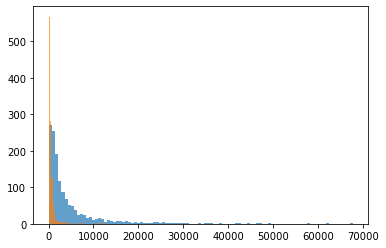

In [243]:
plt.hist(flow_cluster_1, bins=100, alpha=0.7)
plt.hist(flow_cluster_2, bins=100, alpha=0.7);

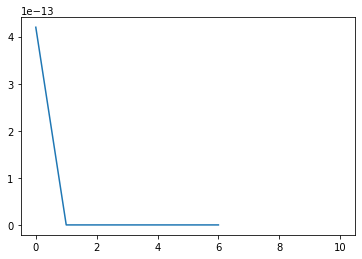

In [244]:
pvals = []
tmp1 = np.array(flow_cluster_1)
tmp2 = np.array(flow_cluster_2)
for n_buckets in range(5,50):
    p = run_chisq_test(tmp1, tmp2, n_buckets, print_res=False)
    if p == np.NaN:
        break
    else:
        pvals += [p]

plt.plot(pvals);